<a href="https://colab.research.google.com/github/riteshpen/Term_Project/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/final_pro/clean_chatgpt_reviews 2.csv')

In [32]:
df.drop(df.columns[0], axis=1, inplace=True)

In [33]:
df.head()

,userName,content,score,thumbsUpCount,at
0,T H (Trudylh20),excellent Im impressed 👌 👏,5,0,28-06-2024 21:07
1,Muhammad bassam adam,perfect,5,0,28-06-2024 20:56
2,Chinaza Okoli,its been so helpful...love it,5,0,28-06-2024 20:54
3,Project House Group Ltd,It's amazing tools help me a lot with my work.,5,0,28-06-2024 20:51
4,Safoan Riyad,I enjoyed ChatGPT. But last update ruined ever...,1,0,28-06-2024 20:50


In [34]:
df.isna().sum()

userName         0
content          0
score            0
thumbsUpCount    0
at               0
dtype: int64

In [35]:
df = df[df.duplicated(subset='content')==False]

In [36]:
import re
def remove_non_english(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Apply the function to the column
df['content'] = df['content'].apply(remove_non_english)


In [37]:
chatGPT_df = df.sample(2000)
chatGPT_df.reset_index(inplace=True)
chatGPT_df.drop(chatGPT_df.columns[0], axis=1, inplace=True)

In [38]:
chatGPT_df.head()

,userName,content,score,thumbsUpCount,at
0,Lucky Duck,very useful in multiple scenarios good respons...,5,0,22-11-2023 20:29
1,Jim Robin,Darned handy utility for asking obscure questions,5,0,21-05-2024 20:06
2,Muzzammil H Gujjar,zabardast,5,0,09-01-2024 13:44
3,Asmat Production,Greatest App For Students,5,0,18-01-2024 06:25
4,Siya Mbatha,Man this is app is cool like about most of wh...,5,0,11-04-2024 20:52


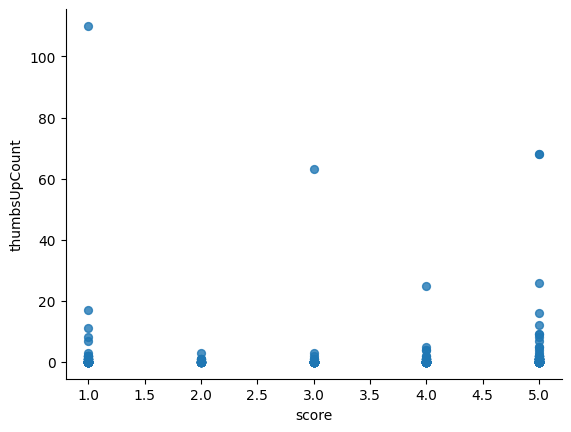

In [39]:
# @title score vs thumbsUpCount

from matplotlib import pyplot as plt
chatGPT_df.plot(kind='scatter', x='score', y='thumbsUpCount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [40]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def score_sentiment(text):
    # Handle potential non-string types by converting to string
    if not isinstance(text, str):
        text = str(text)  # Convert to string if not already

    score = sia.polarity_scores(text)
    compound_score = score['compound']

    # Map the compound score to a scale of 1 to 5
    if compound_score >= 0.6:   # Strongly positive
        return 5
    elif compound_score >= 0.2:  # Positive
        return 4
    elif compound_score > -0.2 and compound_score < 0.2:  # Neutral
        return 3
    elif compound_score > -0.6:  # Negative
        return 2
    else:                         # Strongly negative
        return 1

# Apply scoring to the 'content' column, handling potential mixed types
chatGPT_df['content_score'] = chatGPT_df['content'].apply(score_sentiment) # Removed lambda and type check as score_sentiment now handles non-string types

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [41]:
chatGPT_df.head()


,userName,content,score,thumbsUpCount,at,content_score
0,Lucky Duck,very useful in multiple scenarios good respons...,5,0,22-11-2023 20:29,5
1,Jim Robin,Darned handy utility for asking obscure questions,5,0,21-05-2024 20:06,3
2,Muzzammil H Gujjar,zabardast,5,0,09-01-2024 13:44,3
3,Asmat Production,Greatest App For Students,5,0,18-01-2024 06:25,5
4,Siya Mbatha,Man this is app is cool like about most of wh...,5,0,11-04-2024 20:52,4


In [42]:
X = chatGPT_df.drop(["userName","at","content","score"],axis='columns')
y = chatGPT_df['score']

In [43]:
X[X.thumbsUpCount > 0]

,thumbsUpCount,content_score
9,2,5
13,1,4
35,1,4
54,1,3
59,17,5
...,...,...
1920,5,5
1935,7,1
1955,26,5
1986,1,5


In [57]:
y.loc[1920]

5

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
len(X_train)

1600

In [47]:
len(X_test)

400

In [48]:
model_params = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            'fit_intercept': [True, False]
        },
    },
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0],
            'selection': ['random', 'cyclic'],
            'fit_intercept': [True, False]
        },
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
    },
}

# Perform GridSearchCV for each model and store the best models
best_models = {}
for model_name, model_info in model_params.items():
    grid_search = GridSearchCV(estimator=model_info['model'],
                               param_grid=model_info['params'],
                               cv=5)

    grid_search.fit(X_train, y_train)

    best_models[model_name] = {
        'model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }

# Convert best models dictionary to DataFrame
df = pd.DataFrame(best_models).transpose()
df.reset_index(inplace=True)
df.columns = ['Model', 'Best Estimator', 'Best Parameters', 'Best Score']

# Display the DataFrame
df

,Model,Best Estimator,Best Parameters,Best Score
0,linear_regression,LinearRegression(),{'fit_intercept': True},0.190236
1,ridge,"Ridge(alpha=0.1, solver='sag')","{'alpha': 0.1, 'fit_intercept': True, 'solver'...",0.190728
2,lasso,"Lasso(alpha=0.1, selection='random')","{'alpha': 0.1, 'fit_intercept': True, 'selecti...",0.183428
3,decision_tree,"DecisionTreeRegressor(criterion='poisson', max...","{'criterion': 'poisson', 'max_depth': 20, 'min...",0.240233
4,random_forest,"(DecisionTreeRegressor(max_depth=10, max_featu...","{'max_depth': 10, 'min_samples_leaf': 2, 'min_...",0.242281


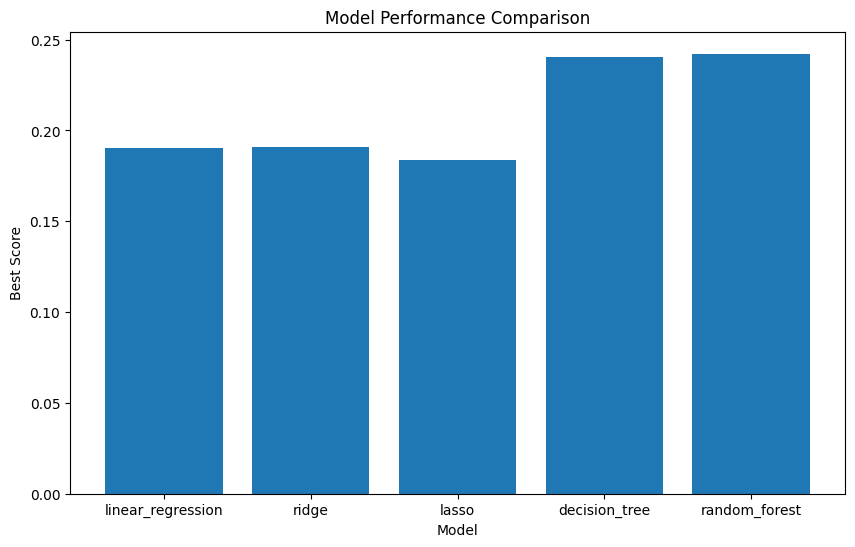

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Best Score'])
plt.xlabel('Model')
plt.ylabel('Best Score')
_ = plt.title('Model Performance Comparison')

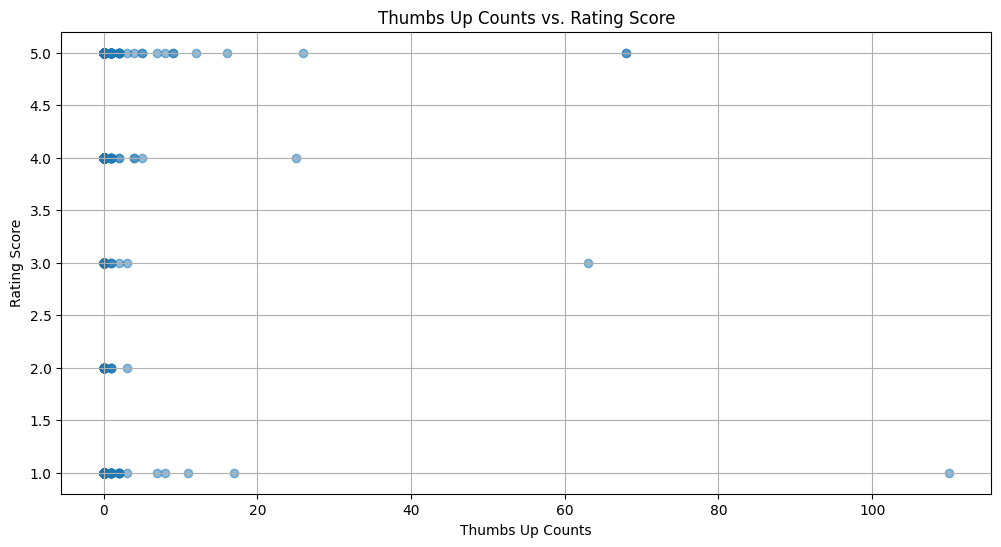

In [72]:
# Assuming 'chatGPT_df' is your DataFrame with 'content_score' and 'score' columns
plt.figure(figsize=(12, 6))
plt.scatter(chatGPT_df['thumbsUpCount'], chatGPT_df['score'], alpha=0.5)
plt.xlabel('Thumbs Up Counts')
plt.ylabel('Rating Score')
plt.title('Thumbs Up Counts vs. Rating Score')
plt.grid(True)
plt.show()


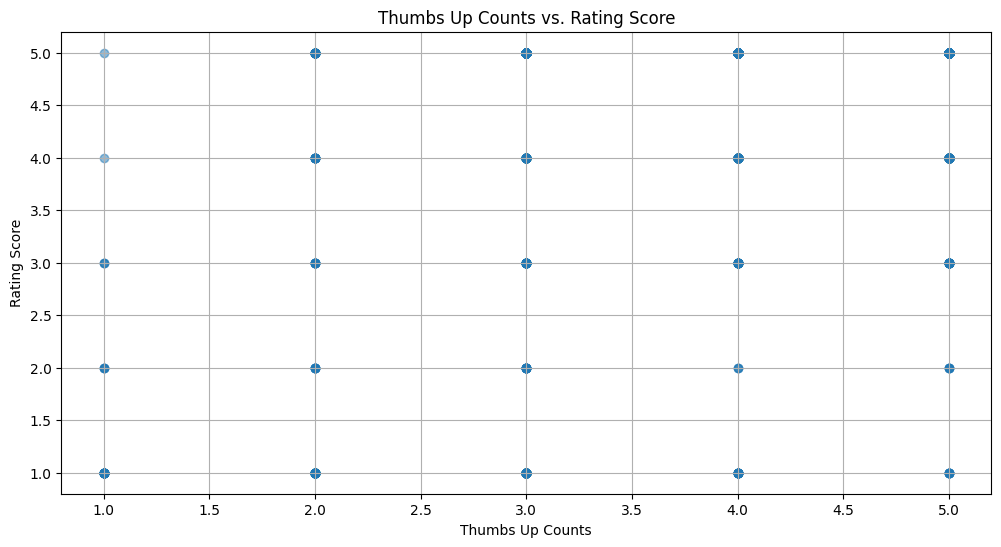

In [75]:
plt.figure(figsize=(12, 6))
plt.scatter(chatGPT_df['content_score'], chatGPT_df['score'], alpha=0.5)
plt.xlabel('Thumbs Up Counts')
plt.ylabel('Rating Score')
plt.title('Thumbs Up Counts vs. Rating Score')
plt.grid(True)
plt.show()

In [50]:
model = RandomForestRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

In [51]:
model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=10)

In [52]:
model.score(X_train, y_train)

0.25950903444201356

In [53]:
model.score(X_test, y_test)

0.31658901640812387

In [60]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r_squared}")

Mean Squared Error: 1.0255265219779692
Mean Absolute Error: 0.7093304407110249
R-squared: 0.31658901640812387


Predictions (thumbsUpCount, ContentScore) -> rating score

In [55]:
model.predict([[0,4]]) # rounds to 5

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([4.58976357])

In [56]:
model.predict([[0,5]]) # rounds to 5

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([4.78368243])

In [58]:
model.predict([[5,5]])  # rounds to 3

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([4.84480934])